In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class_dict = {0:'ACK', 1:'BCC', 2: 'MEL', 3: 'NEV', 4: 'SCC', 5: 'SEK'}

class ImageTabularDataset(Dataset):
    def __init__(self, df, image_root, tabular_cols, transform=None):
        """
        Args:
            df: pandas DataFrame with tabular features and img_id column
            image_root: root folder containing images in class subfolders
            tabular_cols: list of columns in tabular data to use as features
            transform: torchvision transforms for images
        """
        self.df = df
        self.image_root = image_root
        self.tabular_cols = tabular_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
    
        # Image path
        img_path = os.path.join(self.image_root, class_dict[row["diagnostic"]], row["img_id"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
    
        # Tabular features: convert each value to float explicitly
        tab_features = torch.tensor([float(row[col]) for col in self.tabular_cols], dtype=torch.float32)
    
        # Label
        label = torch.tensor(row["diagnostic"], dtype=torch.long)
    
        return {"image": image, "tab": tab_features, "label": label}


In [3]:
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

In [4]:
import os
import pandas as pd 

train_df = pd.read_csv("tabular_data/train.csv") 
dsel_df  = pd.read_csv("tabular_data/dsel.csv") 
test_df  = pd.read_csv("tabular_data/test.csv") 


DATA_DIR = "./output"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "dsel")   # use DSEL as validation or change later
TEST_DIR  = os.path.join(DATA_DIR, "test")

In [5]:
tabular_cols = [c for c in train_df.columns if c not in ["img_id", "diagnostic", "class_idx"]]

train_ds = ImageTabularDataset(train_df, TRAIN_DIR, tabular_cols, transform=train_tfms)
dsel_ds  = ImageTabularDataset(dsel_df, VAL_DIR, tabular_cols, transform=val_tfms)
test_ds  = ImageTabularDataset(test_df, TEST_DIR, tabular_cols, transform=val_tfms)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
dsel_loader  = DataLoader(dsel_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

In [6]:
train_ds[0]

{'image': tensor([[[ 0.9132,  0.8961,  0.8961,  ...,  1.0331,  1.0502,  1.0673],
          [ 0.8961,  0.8961,  0.8961,  ...,  1.0502,  1.0331,  1.0502],
          [ 0.9132,  0.8961,  0.8789,  ...,  1.0502,  1.0331,  1.0502],
          ...,
          [ 0.1597,  0.0056,  0.3309,  ...,  0.7762,  0.7591,  0.7591],
          [ 0.0398,  0.0569,  0.3309,  ...,  0.7591,  0.7248,  0.7248],
          [ 0.0056,  0.1254,  0.2111,  ...,  0.8789,  0.7762,  0.7419]],
 
         [[ 0.7479,  0.7479,  0.7129,  ...,  0.8529,  0.8704,  0.9055],
          [ 0.7479,  0.7479,  0.7304,  ...,  0.8704,  0.8529,  0.8880],
          [ 0.7479,  0.7304,  0.6954,  ...,  0.8704,  0.8704,  0.8880],
          ...,
          [ 0.0126, -0.1625,  0.1702,  ...,  0.6254,  0.5903,  0.5553],
          [-0.1275, -0.1099,  0.1702,  ...,  0.6254,  0.5553,  0.5203],
          [-0.1450, -0.0574,  0.0476,  ...,  0.7654,  0.6254,  0.5553]],
 
         [[ 0.7054,  0.6879,  0.6705,  ...,  0.8099,  0.8274,  0.9145],
          [ 0.6879,

### Encoder 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultimodalEncoder(nn.Module):
    def __init__(self, image_dim=512, tabular_dim=128, embed_dim=128, tab_input_dim=50):
        super().__init__()
        
        # Image encoder 
        self.encoder_image = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, image_dim),
            nn.ReLU(),
            nn.Linear(image_dim, embed_dim)
        )
        
        # Tabular encoder
        self.encoder_tabular = nn.Sequential(
            nn.Linear(tab_input_dim, tabular_dim), nn.ReLU(),
            nn.Linear(tabular_dim, embed_dim)
        )
        
        # Learnable logit scale for contrastive / symile loss
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1/0.07))
    
    def forward(self, images, tabular):
        img_embed = self.encoder_image(images)
        tab_embed = self.encoder_tabular(tabular)
        
        # Normalize embeddings
        img_embed = F.normalize(img_embed, dim=1)
        tab_embed = F.normalize(tab_embed, dim=1)
        
        return img_embed, tab_embed, self.logit_scale.exp()


In [8]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def train_multimodal(model, train_loader, val_loader=None, 
                     loss_fn=None, optimizer=None, 
                     device="cuda", num_epochs=50, print_every=1):
    """
    Train a multimodal encoder (image + tabular) with Symile or other contrastive loss.

    Args:
        model: nn.Module
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation (optional)
        loss_fn: loss function (e.g., Symile())
        optimizer: optimizer
        device: "cuda" or "cpu"
        num_epochs: number of training epochs
        print_every: print loss every N epochs

    Returns:
        model: trained model
        history: list of training losses per epoch
    """
    model = model.to(device)
    history = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = batch["image"].to(device)
            tab = batch["tab"].to(device)
            
            optimizer.zero_grad()
            img_embed, tab_embed, logit_scale_exp = model(images, tab)
            
            # Normalize embeddings
            img_embed = F.normalize(img_embed, dim=1)
            tab_embed = F.normalize(tab_embed, dim=1)
            
            # Compute loss
            loss = loss_fn([img_embed, tab_embed], logit_scale_exp)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        history.append(avg_loss)
        
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")
            
            # Optional validation loop
            if val_loader is not None:
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch in val_loader:
                        images = batch["image"].to(device)
                        tab = batch["tab"].to(device)
                        img_embed, tab_embed, logit_scale_exp = model(images, tab)
                        img_embed = F.normalize(img_embed, dim=1)
                        tab_embed = F.normalize(tab_embed, dim=1)
                        val_loss += loss_fn([img_embed, tab_embed], logit_scale_exp).item()
                val_loss /= len(val_loader)
                print(f"Validation Loss: {val_loss:.4f}")
                model.train()

    return model, history


In [10]:
from symile import Symile
import numpy as np

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = MultimodalEncoder(tab_input_dim=len(tabular_cols)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
symile_loss_fn = Symile()

trained_model, history = train_multimodal(
    model,
    train_loader=train_loader,
    val_loader=dsel_loader,   # optional
    loss_fn=symile_loss_fn,
    optimizer=optimizer,
    device=device,
    num_epochs=20
)

Epoch 1/20: 100%|█████████████████████████████████████████████| 44/44 [00:30<00:00,  1.42it/s]


Epoch 1/20 | Train Loss: 3.4919
Validation Loss: 3.4012


Epoch 2/20: 100%|█████████████████████████████████████████████| 44/44 [00:31<00:00,  1.42it/s]


Epoch 2/20 | Train Loss: 3.3956
Validation Loss: 3.3910


Epoch 3/20: 100%|█████████████████████████████████████████████| 44/44 [00:31<00:00,  1.41it/s]


Epoch 3/20 | Train Loss: 3.3847
Validation Loss: 3.3759


Epoch 4/20: 100%|█████████████████████████████████████████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 4/20 | Train Loss: 3.3608
Validation Loss: 3.3789


Epoch 5/20: 100%|█████████████████████████████████████████████| 44/44 [00:31<00:00,  1.42it/s]


Epoch 5/20 | Train Loss: 3.3497
Validation Loss: 3.3562


Epoch 6/20: 100%|█████████████████████████████████████████████| 44/44 [00:31<00:00,  1.40it/s]


Epoch 6/20 | Train Loss: 3.3500
Validation Loss: 3.3817


Epoch 7/20: 100%|█████████████████████████████████████████████| 44/44 [00:31<00:00,  1.42it/s]


Epoch 7/20 | Train Loss: 3.3272
Validation Loss: 3.3453


Epoch 8/20: 100%|█████████████████████████████████████████████| 44/44 [00:31<00:00,  1.42it/s]


Epoch 8/20 | Train Loss: 3.3061
Validation Loss: 3.3768


Epoch 9/20: 100%|█████████████████████████████████████████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 9/20 | Train Loss: 3.3070
Validation Loss: 3.3651


Epoch 10/20: 100%|████████████████████████████████████████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 10/20 | Train Loss: 3.2653
Validation Loss: 3.3243


Epoch 11/20: 100%|████████████████████████████████████████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 11/20 | Train Loss: 3.2671
Validation Loss: 3.3110


Epoch 12/20: 100%|████████████████████████████████████████████| 44/44 [00:30<00:00,  1.42it/s]


Epoch 12/20 | Train Loss: 3.2330
Validation Loss: 3.3084


Epoch 13/20: 100%|████████████████████████████████████████████| 44/44 [00:30<00:00,  1.42it/s]


Epoch 13/20 | Train Loss: 3.2179
Validation Loss: 3.3339


Epoch 14/20: 100%|████████████████████████████████████████████| 44/44 [00:30<00:00,  1.42it/s]


Epoch 14/20 | Train Loss: 3.2084
Validation Loss: 3.2930


Epoch 15/20: 100%|████████████████████████████████████████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 15/20 | Train Loss: 3.1705
Validation Loss: 3.3554


Epoch 16/20: 100%|████████████████████████████████████████████| 44/44 [00:31<00:00,  1.41it/s]


Epoch 16/20 | Train Loss: 3.1946
Validation Loss: 3.2845


Epoch 17/20: 100%|████████████████████████████████████████████| 44/44 [00:39<00:00,  1.12it/s]


Epoch 17/20 | Train Loss: 3.1567
Validation Loss: 3.3077


Epoch 18/20: 100%|████████████████████████████████████████████| 44/44 [00:31<00:00,  1.42it/s]


Epoch 18/20 | Train Loss: 3.1440
Validation Loss: 3.2754


Epoch 19/20: 100%|████████████████████████████████████████████| 44/44 [00:42<00:00,  1.04it/s]


Epoch 19/20 | Train Loss: 3.1328
Validation Loss: 3.2713


Epoch 20/20: 100%|████████████████████████████████████████████| 44/44 [00:30<00:00,  1.42it/s]


Epoch 20/20 | Train Loss: 3.1232
Validation Loss: 3.3551


### Define RoC 

In [11]:
import torch
import torch.nn.functional as F
from symile import MIPSimilarity
from tqdm import tqdm

def fit_dsel_embeddings(model, dsel_loader, device="cuda"):
    """
    Compute embeddings for the DSEL dataset.
    
    Args:
        model: trained multimodal encoder (image + tabular)
        dsel_loader: DataLoader for DSEL
        device: "cuda" or "cpu"
        
    Returns:
        dsel_embeddings: dict with 'image' and 'tab' embeddings
    """
    model.eval()
    model.to(device)
    dsel_embeddings = {"image": [], "tab": []}

    with torch.no_grad():
        for batch in tqdm(dsel_loader, desc="Computing DSEL embeddings"):
            image = batch['image'].to(device)
            tab = batch['tab'].to(device)

            out_image, out_tab, logit_scale_exp = model(image, tab)
            dsel_embeddings['image'].append(F.normalize(out_image, dim=1))
            dsel_embeddings['tab'].append(F.normalize(out_tab, dim=1))

    # Concatenate all batches
    dsel_embeddings['image'] = torch.cat(dsel_embeddings['image'], dim=0)
    dsel_embeddings['tab']   = torch.cat(dsel_embeddings['tab'], dim=0)

    return dsel_embeddings, logit_scale_exp


In [ ]:
def get_roc_faiss(
    model,
    test_sample,
    faiss_index_image,
    faiss_index_tab,
    logit_scale_exp,
    k=7,
    weights={"image": 0.5, "tab": 0.5},
    device="cuda"
):
    """
    Compute Region of Competence (RoC) using FAISS (cosine similarity).
    FAISS indices must be built on normalized DSEL embeddings.
    """

    model.eval()

    # --- Compute test embeddings ---
    image = test_sample['image'].unsqueeze(0).to(device)
    tab   = test_sample['tab'].unsqueeze(0).to(device)

    with torch.no_grad():
        out_image, out_tab, _ = model(image, tab)
        out_image = F.normalize(out_image, dim=1)
        out_tab   = F.normalize(out_tab, dim=1)

    # --- FAISS NN search ---
    q_image = out_image.cpu().numpy()
    q_tab   = out_tab.cpu().numpy()

    D_img, I_img = faiss_index_image.search(q_image, k)
    D_tab, I_tab = faiss_index_tab.search(q_tab, k)

    # --- Fuse similarities ---
    similarity_scores = (
        weights["image"] * D_img +
        weights["tab"]   * D_tab
    ) * logit_scale_exp

    return I_img[0], similarity_scores[0]


In [12]:
def get_roc(model, test_sample, dsel_embeddings, logit_scale_exp, k=7, weights={"image":0.5, "tab":0.5}, device="cuda"):
    model.eval()
    
    # --- Compute test embeddings ---
    image = test_sample['image'].unsqueeze(0).to(device)
    tab = test_sample['tab'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        out_image, out_tab, logit_scale_exp = model(image, tab)
        out_image = F.normalize(out_image, dim=1)
        out_tab = F.normalize(out_tab, dim=1)
    
    # --- Compute similarity ---
    sim_image = (logit_scale_exp * torch.matmul(out_image, dsel_embeddings['image'].T)).squeeze()
    sim_tab   = (logit_scale_exp * torch.matmul(out_tab, dsel_embeddings['tab'].T)).squeeze()
    
    similarity_scores = weights['image'] * sim_image + weights['tab'] * sim_tab
    
    # --- Ensure k does not exceed available samples ---
    k = min(k, similarity_scores.numel())
    topk_values, topk_indices = torch.topk(similarity_scores, k)
    
    return topk_indices.cpu().numpy(), topk_values.cpu().numpy()

In [13]:
# Step 1: Compute DSEL embeddings
dsel_embeddings, logit_scale_exp = fit_dsel_embeddings(trained_model, dsel_loader, device="cuda")

Computing DSEL embeddings: 100%|██████████████████████████████| 15/15 [00:09<00:00,  1.55it/s]


In [14]:
# Step 2: Pick a test sample
test_sample = test_ds[100]

# Step 3: Get top-K closest DSEL samples
topk_indices, topk_scores = get_roc(trained_model, test_sample, dsel_embeddings, logit_scale_exp, k=5)
print(f"True label: {test_sample['label']}")
print("Top 7 DSEL indices:", topk_indices)
print("Similarity scores:", topk_scores)


True label: 3
Top 7 DSEL indices: [328 266 442 431 165]
Similarity scores: [12.8394985 12.49692   12.460397  12.384409  12.278476 ]


In [15]:
dsel_embeddings

{'image': tensor([[-0.0180,  0.1090, -0.0671,  ..., -0.0444,  0.0172, -0.0387],
         [-0.0116, -0.0196, -0.0957,  ...,  0.0250, -0.0581,  0.0458],
         [ 0.0205,  0.0200, -0.0961,  ...,  0.0059, -0.0750, -0.0364],
         ...,
         [ 0.0495,  0.0351, -0.0508,  ..., -0.0291, -0.0477, -0.0085],
         [-0.0241,  0.0803,  0.0386,  ...,  0.0127,  0.0041,  0.0216],
         [ 0.0214,  0.0521, -0.0416,  ..., -0.0451, -0.0053, -0.0131]],
        device='cuda:0'),
 'tab': tensor([[-0.0364, -0.0124, -0.0253,  ..., -0.0747, -0.0072,  0.0146],
         [-0.0465, -0.0618,  0.0003,  ...,  0.0049, -0.0855,  0.0018],
         [ 0.0029, -0.0900,  0.0311,  ..., -0.0450, -0.0728,  0.0073],
         ...,
         [-0.0369, -0.0025, -0.0145,  ..., -0.0718, -0.0098,  0.0143],
         [-0.0616, -0.0090, -0.0451,  ..., -0.1089, -0.0177, -0.0444],
         [-0.0436, -0.0094, -0.0287,  ..., -0.0729,  0.0026,  0.0139]],
        device='cuda:0')}

In [16]:
import matplotlib.pyplot as plt
import torch

# ---------------------------
# Unnormalize image (ImageNet)
# ---------------------------
def unnormalize_img(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1)
    img_tensor = img_tensor * std + mean
    img_tensor = img_tensor.clamp(0, 1)
    return img_tensor


# ------------------------------------------------------
# Plot test image next to Top-K closest DSEL images
# ------------------------------------------------------
def plot_topk(test_sample, test_image_tensor, topk_indices, dsel_dataset, k=7):
    """
    test_sample:    dict with 'label'
    test_image_tensor: model input image (unnormalized)
    topk_indices: list or tensor of DSEL indices
    dsel_dataset: your validation (DSEL) dataset
    """
    
    test_label = test_sample["label"]
    
    # Load DSEL images + labels
    dsel_imgs = []
    dsel_labels = []

    for idx in topk_indices:
        img = dsel_dataset[idx]["image"]  # already tensor (CxHxW)
        label = dsel_dataset[idx]["label"]
        dsel_imgs.append(img)
        dsel_labels.append(label)

    # --- PLOT ---
    plt.figure(figsize=(20, 4))

    # Plot test image
    plt.subplot(1, k + 1, 1)
    plt.imshow(unnormalize_img(test_image_tensor.cpu()).permute(1, 2, 0))
    plt.title(f"TEST\nLabel: {test_label}")
    plt.axis("off")

    # Plot DSEL images
    for i in range(k):
        plt.subplot(1, k + 1, i + 2)
        plt.imshow(unnormalize_img(dsel_imgs[i].cpu()).permute(1, 2, 0))
        plt.title(f"DSEL {i+1}\nLabel: {dsel_labels[i]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


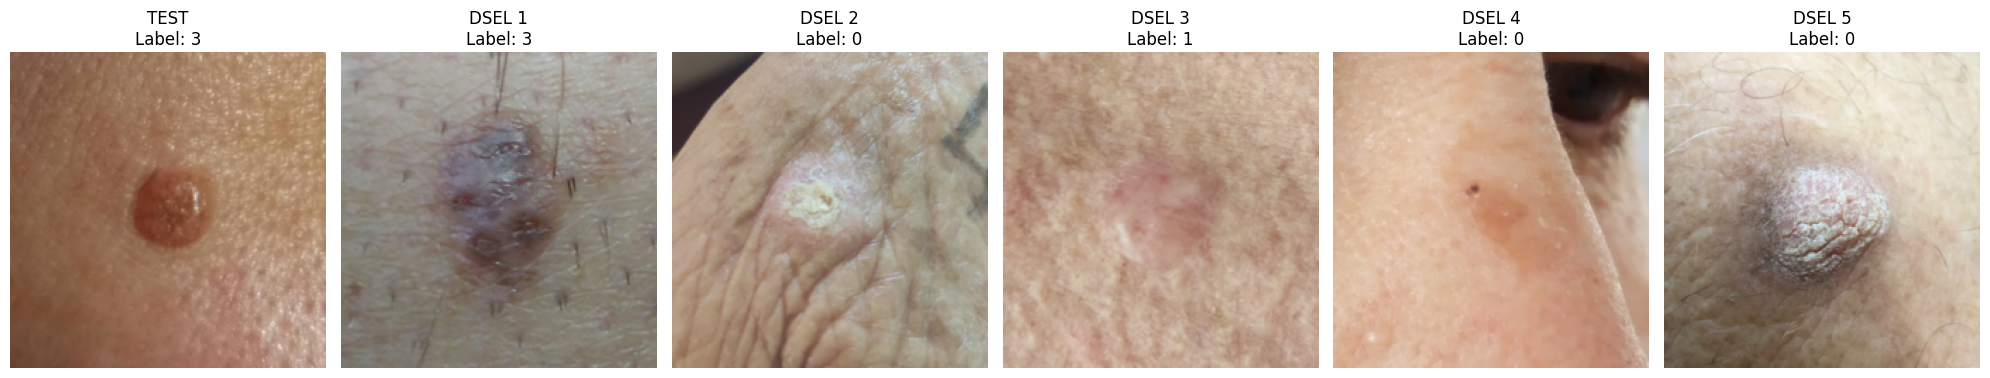

In [17]:
# test sample
test_sample = test_ds[206]
test_img = test_sample["image"]

# plot
plot_topk(
    test_sample=test_sample,
    test_image_tensor=test_img,
    topk_indices=topk_indices,   # from get_roc()
    dsel_dataset=dsel_ds,    # your DSEL dataset
    k=len(topk_indices)
)

### Load base models 

In [89]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
from catboost import CatBoostClassifier



X_train = train_df.drop(["diagnostic", "img_id"], axis=1)
y_train = train_df["diagnostic"] 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=200, verbose=0, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric="mlogloss", random_state=42), 
    "MLP": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42),
    # "SVC": SVC(probability=True, random_state=42), 
    
}

base_tabular_models = [] 
for name, model in tqdm(models.items()):
    print(f"\nTraining {name}...")
    
    model.fit(X_train_scaled, y_train)
    
    base_tabular_models.append(model)

 25%|██████████████▊                                            | 1/4 [00:00<00:00,  5.00it/s]


Training RandomForest...

Training CatBoost...


 50%|█████████████████████████████▌                             | 2/4 [00:00<00:00,  3.66it/s]


Training XGBoost...


 75%|████████████████████████████████████████████▎              | 3/4 [00:00<00:00,  3.14it/s]


Training MLP...


100%|███████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


In [21]:
import torch
from torchvision import models
import torch.nn as nn

# Step 1: Instantiate the model architecture
num_classes = 6  
model_resnet_18 = models.resnet18(pretrained=False)
model_resnet_18.fc = nn.Linear(model_resnet_18.fc.in_features, num_classes)

save_path = "resnet_18_best.pth"
model_resnet_18.load_state_dict(torch.load(save_path, map_location=device))

# Step 3: Evaluation mode
model_resnet_18.to(device)


model_resnet_34 = models.resnet34(pretrained=False)
model_resnet_34.fc = nn.Linear(model_resnet_34.fc.in_features, num_classes)
save_path = "resnet_34_best.pth"
model_resnet_34.load_state_dict(torch.load(save_path, map_location=device))
# Step 3: Evaluation mode
model_resnet_34.to(device)


model_efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, num_classes)

save_path = "efficientnet_b0_best.pth"
model_efficientnet.load_state_dict(torch.load(save_path, map_location=device))

# Step 3: Evaluation mode
model_efficientnet.to(device)


model_mobilenetv2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model_mobilenetv2.classifier[1] = nn.Linear(model_mobilenetv2.classifier[1].in_features, num_classes)

save_path = "mobilenet_v2_best.pth"
model_mobilenetv2.load_state_dict(torch.load(save_path, map_location=device))

# Step 3: Evaluation mode
model_mobilenetv2.to(device)


# model_shufflenet = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
# model_shufflenet.fc = nn.Linear(model_shufflenet.fc.in_features, num_classes)

# save_path = "shufflenet_best.pth"
# model_shufflenet.load_state_dict(torch.load(save_path, map_location=device))

# # Step 3: Evaluation mode
# model_shufflenet.to(device)


model_regnet = models.regnet_y_400mf(weights=models.RegNet_Y_400MF_Weights.IMAGENET1K_V1)
# Replace classifier
model_regnet.fc = nn.Linear(model_regnet.fc.in_features, num_classes)
save_path = "model_regnet_best.pth"
model_regnet.load_state_dict(torch.load(save_path, map_location=device))

model_regnet = model_regnet.to(device)



base_image_models = [model_resnet_18.eval(), 
                     model_resnet_34.eval(), 
                     model_efficientnet.eval(), 
                     model_mobilenetv2.eval(), 
                     # model_shufflenet.eval(), 
                     model_regnet.eval()
                    ]

In [22]:
import torch
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)
from sklearn.preprocessing import label_binarize
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Ensure models are on device and in eval mode
for model in base_image_models:
    model.to(device)
    model.eval()

# Number of classes
NUM_CLASSES = 6  # adjust as per your dataset

# Store results
model_metrics = {}

for idx, model in enumerate(base_image_models):
    y_true = []
    y_pred = []
    y_probs = []

    for sample in test_ds:
        x = sample['image'].unsqueeze(0).to(device)  # add batch dim
        label = sample['label']
        if isinstance(label, torch.Tensor):
            label = label.item()

        with torch.no_grad():
            outputs = model(x)
            probs = torch.softmax(outputs, dim=1)
            pred = probs.argmax(dim=1).item()

        y_true.append(label)
        y_pred.append(pred)
        y_probs.append(probs.cpu().numpy()[0])

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # AUROC (one-hot encode y_true)
    try:
        y_true_oh = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
        auroc = roc_auc_score(y_true_oh, y_probs, average="macro", multi_class="ovr")
    except ValueError:
        auroc = float("nan")  # in case only one class present

    # Store
    model_metrics[f"model_{idx}"] = {
        "Accuracy": acc,
        "Balanced Acc": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUROC": auroc
    }

    print(f"Model {idx} Metrics:")
    print(model_metrics[f"model_{idx}"])


Model 0 Metrics:
{'Accuracy': 0.7695652173913043, 'Balanced Acc': 0.6612677720325997, 'Precision': 0.795901401966913, 'Recall': 0.6612677720325997, 'F1': 0.7042440678119926, 'AUROC': 0.9260229475849853}
Model 1 Metrics:
{'Accuracy': 0.7434782608695653, 'Balanced Acc': 0.6355002366685386, 'Precision': 0.7249562344836734, 'Recall': 0.6355002366685386, 'F1': 0.6618292770503551, 'AUROC': 0.903626749043332}
Model 2 Metrics:
{'Accuracy': 0.7391304347826086, 'Balanced Acc': 0.6307935875315105, 'Precision': 0.7032987942902554, 'Recall': 0.6307935875315105, 'F1': 0.6485309482677905, 'AUROC': 0.9094908434591491}
Model 3 Metrics:
{'Accuracy': 0.7195652173913043, 'Balanced Acc': 0.6384886938512162, 'Precision': 0.6816193285334332, 'Recall': 0.6384886938512162, 'F1': 0.6571504496149196, 'AUROC': 0.8973565298201818}
Model 4 Metrics:
{'Accuracy': 0.6826086956521739, 'Balanced Acc': 0.5987475054326993, 'Precision': 0.6824032404570751, 'Recall': 0.5987475054326993, 'F1': 0.6269038555138368, 'AUROC': 0.

### Estimate Competence  

In [24]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import LabelEncoder

def compute_dsel_outputs(image_models, tabular_models, dsel_loader, device="cuda"):
    """
    Compute predictions and/or embeddings on DSEL dataset for competence estimation.
    """
    dsel_preds = {"image": [], "tabular": []}
    dsel_labels = []

    # --- DSEL loop ---
    for batch in dsel_loader:
        images = batch['image'].to(device)
        tabular = batch['tab'].to(device)
        labels = batch['label'].cpu().numpy()
        dsel_labels.extend(labels)

        # Image model outputs
        img_preds_batch = []
        for model in image_models:
            model.eval()
            with torch.no_grad():
                out = model(images)
                probs = F.softmax(out, dim=1).cpu().numpy()
                img_preds_batch.append(probs)
        dsel_preds['image'].append(np.stack(img_preds_batch, axis=0))  # shape: [n_models, batch_size, n_classes]

        # Tabular model outputs
        tab_preds_batch = []
        for model in tabular_models:
            probs = model.predict_proba(tabular.cpu().numpy())
            tab_preds_batch.append(probs)
        dsel_preds['tabular'].append(np.stack(tab_preds_batch, axis=0))  # [n_models, batch_size, n_classes]

    # Concatenate all batches
    dsel_preds['image'] = np.concatenate(dsel_preds['image'], axis=1)   # [n_models, n_samples, n_classes]
    dsel_preds['tabular'] = np.concatenate(dsel_preds['tabular'], axis=1)

    dsel_labels = np.array(dsel_labels)
    return dsel_preds, dsel_labels


In [58]:
def predict_des_weighted(
    test_sample,
    image_models,
    tabular_models,
    dsel_preds,
    dsel_labels,
    topk_indices,
    scaler_tabular,
    weights={"image": 0.5, "tabular": 0.5}
):
    """
    Predict using Dynamic Ensemble Selection with weighted fusion for image and tabular models.
    """

    # -------------------------
    # 1. Competence calculation
    # -------------------------
    roc_labels = dsel_labels[topk_indices]

    # Image base models competence
    img_competences = []
    for i, model in enumerate(image_models):
        preds = dsel_preds["image"][i][topk_indices].argmax(1)
        competence = torch.tensor(preds == roc_labels).float().mean().item()
        img_competences.append(competence)

    # Tabular base models competence
    tab_competences = []
    tab_feat = scaler_tabular.transform(test_sample["tab"].cpu().numpy().reshape(1, -1))

    for i, model in enumerate(tabular_models):
        preds = dsel_preds["tabular"][i][topk_indices].argmax(1)
        competence = torch.tensor(preds == roc_labels).float().mean().item()
        tab_competences.append(competence)

    # Normalize competences → weights per modality
    img_w = torch.tensor(img_competences)
    tab_w = torch.tensor(tab_competences)

    img_w = img_w / img_w.sum() if img_w.sum() > 0 else img_w
    tab_w = tab_w / tab_w.sum() if tab_w.sum() > 0 else tab_w

    # Apply modality weights
    img_w *= weights.get("image", 0.5)
    tab_w *= weights.get("tabular", 0.5)

    # -------------------------
    # 2. Final weighted fusion
    # -------------------------
    combined = 0

    # Image models
    for w, model in zip(img_w, image_models):
        combined += w * model(test_sample["image"].unsqueeze(0).to(device))

    # Tabular models
    for w, model in zip(tab_w, tabular_models):
        tab_probs = torch.tensor(model.predict_proba(tab_feat), device=device)
        combined += w * tab_probs

    # -------------------------
    # 3. Return predicted class
    # -------------------------
    # final_probs = combined.squeeze(0)
    final_probs = combined / combined.sum(dim=1, keepdim=True) 
    pred = combined.argmax().item()
    
    return pred, final_probs


In [90]:
import torch
import torch.nn.functional as F

def predict_des_weighted_balanced(
    test_sample,
    image_models,
    tabular_models,
    dsel_preds,
    dsel_labels,
    topk_indices,
    scaler_tabular,
    device,
    weights={"image": 0.6, "tabular": 0.4},
    eps=1e-6
):
    """
    Balanced DES with class-frequency correction (CUDA-safe).
    """

    # -------------------------
    # 1. Region labels (Tensor!)
    # -------------------------
    roc_labels = torch.as_tensor(
        dsel_labels[topk_indices],
        device=device,
        dtype=torch.long
    )  # (K,)

    # Class imbalance weights
    class_counts = torch.bincount(roc_labels)
    class_weights = 1.0 / (class_counts.float() + eps)
    sample_weights = class_weights[roc_labels]  # (K,)

    # -------------------------
    # 2. Image model competences
    # -------------------------
    img_comp = []
    for i in range(len(image_models)):
        preds = torch.as_tensor(
            dsel_preds["image"][i][topk_indices],
            device=device
        ).argmax(dim=1)

        correct = (preds == roc_labels).float()
        weighted_acc = (correct * sample_weights).sum() / sample_weights.sum()
        img_comp.append(weighted_acc)

    img_w = torch.stack(img_comp)
    img_w = img_w / (img_w.sum() + eps)

    # -------------------------
    # 3. Tabular model competences
    # -------------------------
    tab_comp = []
    for i in range(len(tabular_models)):
        preds = torch.as_tensor(
            dsel_preds["tabular"][i][topk_indices],
            device=device
        ).argmax(dim=1)

        correct = (preds == roc_labels).float()
        weighted_acc = (correct * sample_weights).sum() / sample_weights.sum()
        tab_comp.append(weighted_acc)

    tab_w = torch.stack(tab_comp)
    tab_w = tab_w / (tab_w.sum() + eps)

    # Apply modality weights
    img_w *= weights["image"]
    tab_w *= weights["tabular"]

    # -------------------------
    # 4. Final weighted fusion
    # -------------------------
    combined = torch.zeros(
        image_models[0](test_sample["image"].unsqueeze(0).to(device)).shape,
        device=device
    )

    # Image predictions
    for w, model in zip(img_w, image_models):
        combined += w * model(test_sample["image"].unsqueeze(0).to(device))

    # Tabular predictions (CPU → Tensor → CUDA)
    tab_feat = scaler_tabular.transform(
        test_sample["tab"].cpu().numpy().reshape(1, -1)
    )

    for w, model in zip(tab_w, tabular_models):
        probs = torch.tensor(
            model.predict_proba(tab_feat),
            device=device,
            dtype=torch.float
        )
        combined += w * probs

    # -------------------------
    # 5. Prediction
    # -------------------------
    final_probs = combined / combined.sum(dim=1, keepdim=True) 
    pred = combined.argmax().item()
    
    return pred, final_probs


In [91]:
# --- Step 0: Compute DSEL predictions once ---
dsel_preds, dsel_labels = compute_dsel_outputs(
    image_models=base_image_models,
    tabular_models=base_tabular_models,
    dsel_loader=dsel_loader,
    device=device
)

In [97]:
results = []
true_labels = [] 
results_probs = [] 

for test_sample in tqdm(test_ds):
    topk_indices, topk_scores = get_roc(trained_model, test_sample, dsel_embeddings, logit_scale_exp, k=10)
    y_pred, y_proba = predict_des_weighted(
        test_sample,
        base_image_models,
        base_tabular_models,
        dsel_preds, 
        dsel_labels, 
        topk_indices,
        scaler, 
        weights={"image": 0.15, "tabular": 0.85}
    )
    
    results.append(y_pred)
    results_probs.append(y_proba.detach().cpu().numpy())

    label = test_sample['label']
    # if label is a tensor, convert to int
    if isinstance(label, torch.Tensor):
        label = label.item()
    true_labels.append(label)

100%|███████████████████████████████████████████████████████| 460/460 [00:20<00:00, 22.22it/s]


In [98]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
import numpy as np

# Convert lists to numpy arrays
y_true = np.array(true_labels)
y_pred = np.array(results)
y_proba = np.array(results_probs)

# Accuracy
acc = accuracy_score(y_true, y_pred)

# Precision (macro average for multi-class)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)

# Recall (macro average)
rec = recall_score(y_true, y_pred, average='macro', zero_division=0)

# F1 score (macro average)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

# Balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred)


# auroc = roc_auc_score(y_true, y_proba, multi_class='ovr')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"AUROC: {auroc:.4f}")  # Uncomment if you have probabilities


Accuracy: 0.8522
Precision: 0.8926
Recall: 0.7620
F1 Score: 0.7973
Balanced Accuracy: 0.7620
AUROC: 0.9699


In [70]:
def predict_des_weighted_explain(
    test_sample,
    test_image_tensor,
    image_models,
    tabular_models,
    dsel_preds,
    dsel_labels,
    topk_indices,
    dsel_dataset,
    scaler_tabular,
    weights={"image": 0.5, "tabular": 0.5},
    plot_topk_flag=True
):
    """
    Predict class using Dynamic Ensemble Selection with weighted fusion for image and tabular models,
    and provide detailed explainability per model:
      - model prediction
      - competence
      - weighted contribution

    Args:
        test_sample: dict with 'image', 'tab', 'label'
        test_image_tensor: torch.Tensor, image input
        image_models, tabular_models: lists of trained models
        dsel_preds, dsel_labels: precomputed DSEL predictions and labels
        topk_indices: indices of top-k DSEL samples for this test sample
        dsel_dataset: full DSEL dataset for visualization
        scaler_tabular: scaler for tabular features
        weights: dict, modality weights
        plot_topk_flag: bool, whether to plot top-k DSEL samples

    Returns:
        predicted class (int)
    """

    # ============================
    # 1. Compute per-model competence
    # ============================
    roc_labels = dsel_labels[topk_indices]

    # --- Image models ---
    img_competences = []
    img_preds = []
    img_contributions = []
    for i, model in enumerate(image_models):
        # DSEL predictions for RoC
        preds = dsel_preds["image"][i][topk_indices].argmax(1)
        competence = torch.tensor(preds == roc_labels).float().mean().item()
        img_competences.append(competence)

    # --- Tabular models ---
    tab_competences = []
    tab_preds = []
    tab_contributions = []

    tab_feat = scaler_tabular.transform(test_sample["tab"].cpu().numpy().reshape(1, -1))
    for i, model in enumerate(tabular_models):
        preds = dsel_preds["tabular"][i][topk_indices].argmax(1)
        competence = torch.tensor(preds == roc_labels).float().mean().item()
        tab_competences.append(competence)

    # ============================
    # 2. Normalize competences and apply modality weights
    # ============================
    img_w = torch.tensor(img_competences)
    tab_w = torch.tensor(tab_competences)

    img_w = img_w / img_w.sum() if img_w.sum() > 0 else img_w
    tab_w = tab_w / tab_w.sum() if tab_w.sum() > 0 else tab_w

    img_w *= weights.get("image", 0.5)
    tab_w *= weights.get("tabular", 0.5)

    # ============================
    # 3. Weighted fusion of predictions
    # ============================
    combined = torch.zeros(NUM_CLASSES, device=device)

    print("\n--- Individual Model Contributions ---")
    # Image models
    for i, (w, model) in enumerate(zip(img_w, image_models)):
        probs = torch.softmax(model(test_image_tensor.unsqueeze(0).to(device)), dim=1).squeeze()
        contribution = w * probs
        combined += contribution
        img_preds.append(probs.argmax().item())
        img_contributions.append(contribution.detach().cpu().numpy())
        print(f"Image model {i}: pred={probs.argmax().item()}, competence={img_competences[i]:.3f}, weight={w:.3f}, contribution={contribution.detach().cpu().numpy()}")


    # Tabular models
    for i, (w, model) in enumerate(zip(tab_w, tabular_models)):
        tab_probs = torch.tensor(model.predict_proba(tab_feat), device=device).squeeze()
        contribution = w * tab_probs
        combined += contribution
        tab_preds.append(tab_probs.argmax().item())
        tab_contributions.append(contribution.detach().cpu().numpy())
        print(f"Tabular model {i}: pred={tab_probs.argmax().item()}, competence={tab_competences[i]:.3f}, weight={w:.3f}, contribution={contribution.detach().cpu().numpy()}")


    # ============================
    # 4. Explainability / Visualization
    # ============================
    if plot_topk_flag:
        print("\n--- Explainability Info ---")
        print("Image model competences:", img_competences)
        print("Tabular model competences:", tab_competences)
        print("Applied modality weights:", weights)
        print("Final weighted fusion output:", combined.detach().cpu().numpy())
        # Visualize top-k DSEL samples
        plot_topk(
            test_sample=test_sample,
            test_image_tensor=test_image_tensor,
            topk_indices=topk_indices,
            dsel_dataset=dsel_dataset,
            k=len(topk_indices)
        )

    # ============================
    # 5. Return predicted class
    # ============================
    final_pred = combined.argmax().item()
    print(f"\n>>> Final predicted class: {final_pred}")
    return final_pred


True: 0

--- Individual Model Contributions ---
Image model 0: pred=0, competence=0.600, weight=0.133, contribution=[1.1749054e-01 1.5227938e-02 6.1872226e-05 8.5237343e-06 5.4428278e-04
 1.7706093e-07]
Image model 1: pred=0, competence=0.800, weight=0.178, contribution=[1.68423578e-01 8.82684905e-03 3.71907576e-04 3.69857735e-05
 1.12077774e-04 6.39828522e-06]
Image model 2: pred=0, competence=0.600, weight=0.133, contribution=[0.1154797  0.01543347 0.00049691 0.00014851 0.00150706 0.00026769]
Image model 3: pred=1, competence=0.800, weight=0.178, contribution=[1.9565480e-02 1.5815918e-01 1.8836430e-05 4.1974322e-06 2.9617620e-05
 4.7969633e-07]
Image model 4: pred=0, competence=0.800, weight=0.178, contribution=[1.6170339e-01 1.3228908e-02 2.0988991e-03 3.9143045e-04 2.1167927e-04
 1.4347189e-04]
Tabular model 0: pred=0, competence=1.000, weight=0.056, contribution=[0.0525     0.         0.         0.00111111 0.00027778 0.00166667]
Tabular model 1: pred=0, competence=1.000, weight=0.

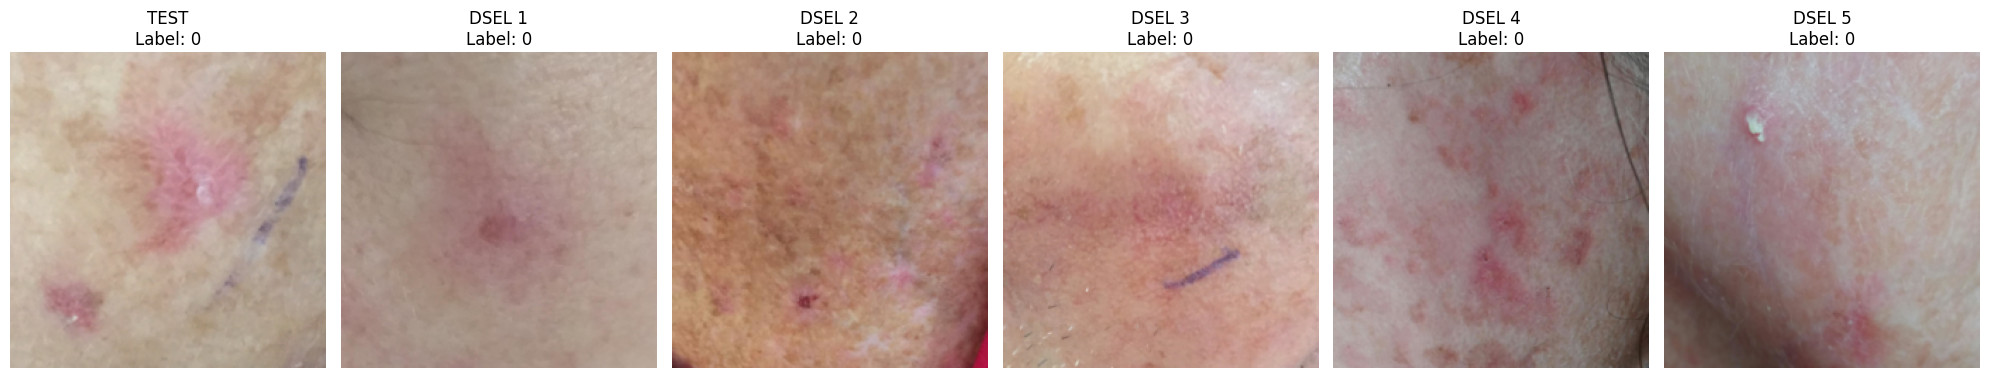


>>> Final predicted class: 0


In [96]:
test_sample = test_ds[77]
print(f"True: {test_sample['label']}")
test_img = test_sample["image"]

topk_indices, topk_scores = get_roc(trained_model, test_sample, dsel_embeddings, logit_scale_exp, k=5)
y_pred = predict_des_weighted_explain(
    test_sample,
    test_img, 
    base_image_models,
    base_tabular_models,
    dsel_preds, 
    dsel_labels, 
    topk_indices,
    dsel_ds,
    scaler, 
    weights={"image": 0.8, "tabular": 0.2})

### AutoprognosisM